# <center> The D-ACO/IDS Project <br>
## <center> (Digital - Ant Colony Optimization/Intrusion Detection System)
### <center> Feature Selection
#### <center> Dataset NBaIoT

In [1]:
# Importação de modulos Python
import os
import time
from datetime import datetime

import numpy as np
import pandas as pd

In [2]:
# Importação das bibiotecas do Sklearn
from sklearn import preprocessing
from joblib import Parallel, delayed
from sklearn.model_selection import StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.metrics import precision_score , recall_score, f1_score, confusion_matrix, log_loss

In [3]:
# Importação da biblioteca Scipy
from scipy import stats, spatial

In [4]:
# Importação das bibliotecas Graficas
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt

# Exibe gráficos na página (inline)
%matplotlib inline

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
seed = 123 # Fixar a semente aleatória dos algoritmos

## Seleção e Apresentação do Dataset

In [7]:
tecnica = 'ACO'
dset_name = 'NBaIoT100'
df = pd.read_csv('../../../../../datasets/dacoga/nbaiot/dsetN-Baiot_v2_100.csv')
df.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0_1_weight,...,HpHp_L0_1_covariance,HpHp_L0_1_pcc,HpHp_L0_01_weight,HpHp_L0_01_mean,HpHp_L0_01_std,HpHp_L0_01_magnitude,HpHp_L0_01_radius,HpHp_L0_01_covariance,HpHp_L0_01_pcc,label
0,34.601760,398.908959,52550.382469,67.717384,403.302501,51712.306449,290.361681,371.306909,56847.712817,3664.475330,...,0.0,0.0,1.000000,60.0,0.000000e+00,60.000000,0.000000e+00,0.0,0.0,0
1,166.897264,74.093675,2.239427,271.018503,74.076204,1.823122,802.782759,74.053501,1.405218,7073.265995,...,0.0,0.0,1.678887,74.0,9.536743e-07,95.268043,9.094947e-13,0.0,0.0,0
2,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.0,0.0,1.000000,60.0,0.000000e+00,60.000000,0.000000e+00,0.0,0.0,0
3,81.573509,361.922677,57800.777918,138.807560,321.869667,60673.771150,426.539988,314.707208,60910.274988,3941.072685,...,0.0,0.0,1.000000,554.0,0.000000e+00,554.000000,0.000000e+00,0.0,0.0,0
4,142.893002,65.017844,45.078160,202.254552,65.919080,47.843152,449.879100,67.102984,49.018986,3714.410039,...,0.0,0.0,1.000000,60.0,0.000000e+00,60.000000,0.000000e+00,0.0,0.0,0


In [8]:
# Start algorithms time
start_time = time.time()

Label
Ataques 0 1966991
Normal 1 513497

Ataques representam 79.2985% do dataset.



<Axes: xlabel='label', ylabel='count'>

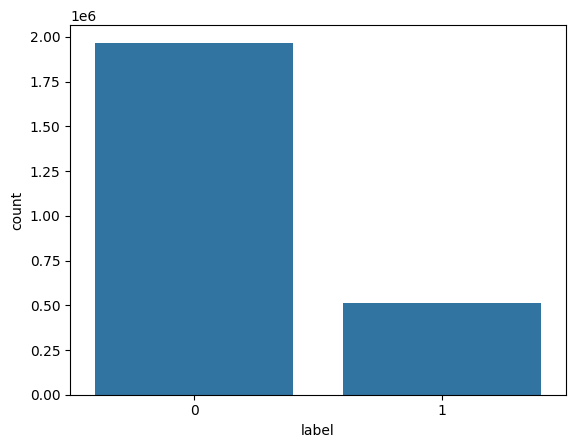

In [9]:
# Verificar o balanceamento das classes
#print(df.label.value_counts())
print('Label')
print('Ataques' , df.label.value_counts().index.tolist()[0], df.label.value_counts()[0])
print('Normal' , df.label.value_counts().index.tolist()[1], df.label.value_counts()[1])

print("\nAtaques representam {:.4f}% do dataset.\n".
      format((df[df.label == 0].shape[0] / df.shape[0]) * 100))

# plotar gráfico de barras para as Classes
sns.countplot(x=df['label'])

In [10]:
print('Return a tuple representing the dimensionality of the DataFrame')
print('Colunas', df.shape[1])
print('Linhas', df.shape[0])

Return a tuple representing the dimensionality of the DataFrame
Colunas 116
Linhas 2480488


In [11]:
xData = df.iloc[:, :-1].values
yData = df.iloc[:, -1].values
atributos = xData.shape[1]

In [12]:
print('Atributos do dataframe', atributos)

Atributos do dataframe 115


In [13]:
# Padronizando os dados
scaler = preprocessing.MinMaxScaler().fit_transform(xData)
#scaler = preprocessing.StandardScaler().fit_transform(xData)
#scaler = preprocessing.RobustScaler().fit_transform(xData)

In [14]:
#X = scaler
X = xData
y = yData

## Funções do Sistema

In [15]:
'''
Pseudo Código

Esta função é usada para obter uma matriz inicial de Feromônios com heurísticas. 
Este é o primeiro método dentre os métodos de heurísticas para obter valores de
Feromônios para cada aresta.

1. Defina a função initPheromone com um parâmetro "atributos"
2. Crie uma matriz tridimensional chamada "pheromone" com dimensões "atributos x atributos x 4" preenchida com zeros
3. Para cada valor "i" de 0 até "atributos - 1":
    3.1. Para cada valor "j" de 0 até "atributos - 1":
        3.1.1. Para cada valor "k" de 0 até 3:
            3.1.1.1. Defina pheromone[i][j][k] como o resultado da função "heuristica" passando "i", "j", e "k" como argumentos
4. Retorne a matriz "pheromone" com a forma: atributos X atributos X 4
'''

# Função para inicializar a matriz de feromônios
def initPheromone(atributos):
    
    # Cria uma matriz tridimensional de zeros com dimensões [atributos, atributos, 4]
    pheromone = np.zeros((atributos, atributos, 4))
    
    # Loop para percorrer cada combinação de pares de atributos
    for i in range(atributos):
        for j in range(atributos):
            
            # Para cada par de atributos (i, j), calcule o valor heurístico para cada uma das 4 posições possíveis
            pheromone[i][j][0] = heuristica(i, j, 0)
            pheromone[i][j][1] = heuristica(i, j, 1)
            pheromone[i][j][2] = heuristica(i, j, 2)
            pheromone[i][j][3] = heuristica(i, j, 3)
    
    # Retorna a matriz de feromônios preenchida
    return pheromone

In [16]:
"""
Pseudo Código

Calcula a importância heurística de uma aresta com base em um estado específico.

Entrada:
    - i, j: Par ordenado representando a importância heurística da aresta.
    - stateCode: Código fornecido para vincular os dois estados das arestas.
      stateCode = 0 se a aresta está entre o estado 0 e 0
                = 1 se a aresta está entre o estado 0 e 1
                = 2 se a aresta está entre o estado 1 e 0
                = 3 se a aresta está entre o estado 1 e 1
Processamento:
    1. Se stateCode for 0 ou 2:
        Retornar o valor em mat_correlacao[i][j]
    
    2. Se stateCode for 1 ou 3:
        Retornar o valor de (1 - mat_correlacao[i][j])

Saida: 
    - Retorna a importância heurística da aresta, que pode ser diretamente de mat_correlacao 
    ou seu valor complementar (1 - valor de mat_correlacao), dependendo do stateCode.
"""

def heuristica(i, j, stateCode):
    # Se a aresta está entre os estados 0->0 ou 1->0
    if stateCode == 0 or stateCode == 2:
        return mat_correlacao[i][j]

    # Se a aresta está entre os estados 0->1 ou 1->1
    if stateCode == 1 or stateCode == 3:
        return (1 - mat_correlacao[i][j])

In [17]:
# Função auxiliar para calcular os pesos baseados na heurística e feromônios
def calculate_weights(proxPossibilidade, i, state_from, state_to, pheromone):
    # Retorna um dicionário contendo os pesos para cada possível próximo atributo j
    return {j: heuristica(i, j, state_to)**alpha * pheromone[i][j][state_to]**beta for j in proxPossibilidade}

In [18]:
def getFormigas(atributos, num_formigas, pheromone):
    # Inicializa a posição de cada formiga em um atributo aleatório e define seu estado inicial (0 ou 1) aleatoriamente
    formigaNos = [np.random.choice(range(atributos), 1).tolist() for _ in range(num_formigas)]
    formigasEstado = [np.random.choice(range(2), 1).tolist() for _ in range(num_formigas)]
    
    # Itera por cada atributo (exceto o último)
    for attribute in range(atributos-1):
        # Itera por cada formiga e atualiza sua posição e estado
        for ant, nodes in enumerate(formigaNos):
            # Encontra os próximos possíveis atributos (aqueles que a formiga ainda não visitou)
            proxPossibilidade = set(range(atributos)) - set(nodes)
            # Obtém o último estado da formiga
            i = formigasEstado[ant][-1]
            
            # Se o último estado selecionado foi 1
            if i:
                # Calcula os pesos para transição de estado 1 para 0 e de 1 para 1
                wt0 = calculate_weights(proxPossibilidade, i, 1, 0, pheromone)
                wt1 = calculate_weights(proxPossibilidade, i, 1, 1, pheromone)
            # Se o último estado selecionado foi 0
            else:
                # Calcula os pesos para transição de estado 0 para 0 e de 0 para 1
                wt0 = calculate_weights(proxPossibilidade, i, 0, 0, pheromone)
                wt1 = calculate_weights(proxPossibilidade, i, 0, 1, pheromone)
            
            # Decide se a formiga irá explorar ou explorar com base nos pesos
            if np.random.rand() < 0.7:
                # Obtém o atributo com maior peso para ambos os estados
                select0, select1 = max(wt0, key=wt0.get), max(wt1, key=wt1.get)
                # Compara os pesos e decide o próximo atributo e estado da formiga
                if wt0[select0] > wt1[select1]:
                    nodes.append(select0)
                    formigasEstado[ant].append(0)
                else:
                    nodes.append(select1)
                    formigasEstado[ant].append(1)
            # Se a formiga decidir explorar
            else:
                # Calcula as probabilidades de seleção para cada estado
                Wt_wt0, Wt_wt1 = sum(wt0.values()), sum(wt1.values())
                P0, P1 = Wt_wt0 / (Wt_wt0 + Wt_wt1), Wt_wt1 / (Wt_wt0 + Wt_wt1)
                
                # Decide aleatoriamente o próximo estado da formiga com base nas probabilidades
                if np.random.choice(range(2), p=[P0, P1]):
                    select1 = np.random.choice(list(proxPossibilidade), p=[wt1[i]/Wt_wt1 for i in proxPossibilidade])
                    nodes.append(select1)
                    formigasEstado[ant].append(1)
                else:            
                    select0 = np.random.choice(list(proxPossibilidade), p=[wt0[i]/Wt_wt0 for i in proxPossibilidade])
                    nodes.append(select0)
                    formigasEstado[ant].append(0)
    
    # Retorna a lista de atributos visitados e seus respectivos estados para cada formiga
    return formigaNos, formigasEstado

In [19]:
'''
Função getSelectedFeatures recebe antNode e antState como argumentos:

    Crie uma lista vazia chamada atributoselect

    Para cada índice i no intervalo do tamanho de antNode:
        Se antState no índice i for verdadeiro:
            Adicione antNode no índice i à lista atributoselect

    Retorne a lista atributoselect
'''

def getSelectedFeatures(antNode, antState):
    """
    Função para selecionar características com base no estado do formigueiro.

    Parâmetros:
    antNode (lista): Lista de nós ou características.
    antState (lista): Lista de estados (booleanos) representando se um nó específico foi selecionado.

    Retorna:
    list: Lista de nós selecionados com base no estado do formigueiro.
    """

    # Inicializando uma lista vazia para armazenar os nós selecionados.
    atributoselect = []

    # Iterando sobre todos os nós em antNode.
    for i in range(len(antNode)):
        # Verificando se o estado do nó atual é True.
        if antState[i]:
            # Adicionando o nó selecionado à lista.
            atributoselect.append(antNode[i])

    # Retornando a lista de nós selecionados.
    return atributoselect

In [20]:
'''
INÍCIO

// Definindo as informações prévias
Variável global pheromone

Função updateF(pMeasure, formigaNos, formigasEstado):

    // Informações sobre a matriz de feromônio
    Variável global pheromone
    
    // Definindo a fração de evaporação
    evapFrac <- 0.05

    // Calculando a evaporação para a matriz
    PARA CADA elemento em pheromone:
        elemento <- elemento * (1-evapFrac)
    
    // Identificando a formiga com melhor desempenho
    melhor <- posição do maior valor em pMeasure
    
    // Obtendo os nós e estados da formiga de melhor desempenho
    antNode <- formigaNos na posição [melhor]
    antState <- formigasEstado na posição [melhor]
    
    // Fração de mudança é igual à fração de evaporação
    Change <- evapFrac
    
    // Atualizando a matriz de feromônio
    PARA i DE 0 ATÉ (atributos-1):
        SE (antState[i] == 0 e antState[i+1] == 0) ENTÃO:
            ind <- 0
        SE (antState[i] == 0 e antState[i+1] == 1) ENTÃO:
            ind <- 1
        SE (antState[i] == 1 e antState[i+1] == 0) ENTÃO:
            ind <- 2
        SE (antState[i] == 1 e antState[i+1] == 1) ENTÃO:
            ind <- 3
        FIM SE
        
        // Atualizando o valor do feromônio com base na mudança e simetria
        pheromone[antNode[i], antNode[i+1], ind] <- pheromone[antNode[i], antNode[i+1], ind] + pheromone[antNode[i], antNode[i+1], ind] * Change
        pheromone[antNode[i+1], antNode[i], ind] <- pheromone[antNode[i+1], antNode[i], ind] + pheromone[antNode[i+1], antNode[i], ind] * Change

    FIM PARA

FIM Função

FIM
'''

def updateF(pMeasure, formigaNos, formigasEstado):
    """
    Atualiza a matriz de feromônio com base nas medidas de desempenho, 
    nós visitados e estados dos nós das formigas.

    Parâmetros:
    - pMeasure: Lista de pontuações de desempenho para formigas.
    - formigaNos: Lista de nós visitados pelas formigas.
    - formigasEstado: Lista dos estados dos nós visitados pelas formigas.

    A função modifica a variável global pheromone.
    """
    # Definindo a matriz de feromônio como uma variável global para que possa ser acessada e modificada dentro desta função
    # A matriz de feromônio é uma variável global
    global pheromone

    # Estabelecendo a taxa de evaporação do feromônio
    # Fração para evaporação do feromônio
    evapFrac = 0.05

    # Criando uma função lambda para calcular a evaporação do feromônio
    # Função lambda para calcular a evaporação do feromônio
    evap = lambda x: x * (1-evapFrac)

    # Evaporando o feromônio existente em toda a matriz
    # Aplica evaporação a toda matriz de feromônio
    pheromone = evap(pheromone)

    # Identificando a formiga com o melhor desempenho
    # Encontra o índice da formiga com melhor desempenho
    melhor = np.argmax(pMeasure)

    # Selecionando os nós visitados e estados da formiga com o melhor desempenho
    # Seleciona os nós visitados e estados da formiga com melhor desempenho
    antNode = formigaNos[melhor]
    antState = formigasEstado[melhor]

    # Estabelecendo a taxa de mudança no feromônio
    # A fração de mudança é igual à fração de evaporação
    Change = evapFrac

   # Atualizando a matriz de feromônio com base nos nós e estados visitados pela formiga com melhor desempenho
    # Atualiza a matriz de feromônio com base nos nós e estados visitados pela formiga com melhor desempenho
    for i in range(atributos-1):
        # Identificando o índice com base nos estados consecutivos visitados
        # Determine o índice com base nos estados consecutivos visitados
        if antState[i] == 0 and antState[i+1] == 0:
            ind = 0
        if antState[i] == 0 and antState[i+1] == 1:
            ind = 1
        if antState[i] == 1 and antState[i+1] == 0:
            ind = 2
        if antState[i] == 1 and antState[i+1] == 1:
            ind = 3       
        
        # Incrementando a quantidade de feromônio entre dois nós consecutivos visitados pela formiga
        # Atualiza o feromônio para o caminho entre os nós consecutivos visitados
        pheromone[antNode[i], antNode[i+1], ind] += pheromone[antNode[i], antNode[i+1], ind]*Change
        
        # Garantindo que a atualização seja simétrica (ida e volta)
        # Também atualiza o feromônio no caminho oposto (simetria)
        pheromone[antNode[i+1], antNode[i], ind] += pheromone[antNode[i+1], antNode[i], ind]*Change 

In [21]:
'''
INÍCIO

Função getAcuracia(xData, yData):

    // Inicializa a validação cruzada estratificada
    kf <- StratifiedKFold com 5 divisões e mistura ativada
    kf obtém o número total de divisões
    
    // Definindo variáveis globais
    Variáveis globais: clf, accAco, y_pred_aco, y_test_aco, y_probas
    
    // Lista para armazenar acurácias das iterações
    accAco <- lista vazia
    
    // Realizar validação cruzada estratificada
    PARA CADA conjunto de índices de treino e teste em kf.split(xData, yData):

        // Dividindo os dados em conjuntos de treino e teste com base nos índices
        X_train_aco <- xData nos índices de treino
        y_train_aco <- yData nos índices de treino
        X_test_aco <- xData nos índices de teste
        y_test_aco <- yData nos índices de teste

        // Criando e treinando o classificador
        clf <- LinearDiscriminantAnalysis
        clf treina com X_train_aco e y_train_aco

        // Fazendo previsões com o classificador
        y_probas <- probabilidades preditas por clf para X_test_aco
        y_pred_aco <- classificações preditas por clf para X_test_aco

        // Calculando acurácia e adicionando à lista
        acuracia <- acurácia entre y_test_aco e y_pred_aco
        Adicione acuracia a accAco
        
    FIM PARA
    
    // Retorne a média das acurácias armazenadas
    RETORNE média de accAco

FIM Função

FIM
'''

def getAcuraciaold(xData, yData):
    """
    Calcula a acurácia média utilizando validação cruzada estratificada em 5 divisões 
    usando Linear Discriminant Analysis como classificador.

    Parâmetros:
    - xData: Dados de entrada/features.
    - yData: Rótulos/labels dos dados.
    
    Retorna:
    - Acurácia média obtida nas 5 divisões.
    """
    
    # Inicializando a validação cruzada estratificada com 5 divisões e mistura ativada
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    kf.get_n_splits()

    # Definindo algumas variáveis como globais para que possam ser acessadas/modificadas fora desta função se necessário
    global clf, accAco, y_pred_aco, y_test_aco, y_probas
        
    # Inicializando a lista para armazenar as acurácias de cada divisão
    accAco = []
    precisionAco = []
    recallAco = []
    f1scoreAco = []
    crocAco = []
    
    # Iterando pelos índices de treino e teste para validação cruzada estratificada
    for train_index, test_index in kf.split(xData, yData):
        
        # Dividindo os dados em conjuntos de treino e teste com base nos índices fornecidos
        X_train_aco = xData[train_index]
        y_train_aco = yData[train_index]
        X_test_aco = xData[test_index]
        y_test_aco = yData[test_index]

        # Criando e treinando o classificador Linear Discriminant Analysis
        clf = LinearDiscriminantAnalysis()
        clf.fit(X_train_aco, y_train_aco)
        
        # Fazendo previsões usando o classificador treinado
        y_probas = clf.predict_proba(X_test_aco)
        y_pred_aco = clf.predict(X_test_aco)
        
        # Calculando acurácia para a divisão atual e adicionando à lista
        accAco.append(accuracy_score(y_test_aco, y_pred_aco))
        precisionAco.append(precision_score(y_test_aco, y_pred_aco))
        recallAco.append(recall_score(y_test_aco, y_pred_aco))
        f1scoreAco.append(f1_score(y_test_aco, y_pred_aco))
        crocAco.append(roc_auc_score(y_test_aco, y_pred_aco))

        # Calculando a matriz de confusão para a divisão atual
        confusao_atual = confusion_matrix(y_test_aco, y_pred_aco)
        if confusao_acumulada is None:
            confusao_acumulada = confusao_atual
        else:
            confusao_acumulada += confusao_atual
    
    # Retornando a acurácia média das 5 divisões
    return np.mean(accAco), np.mean(precisionAco), np.mean(recallAco), np.mean(f1scoreAco), np.mean(crocAco),confusao_acumulada

In [22]:
def fit_and_evaluate(train_index, test_index, xData, yData):
    X_train, y_train = xData[train_index], yData[train_index]
    X_test, y_test = xData[test_index], yData[test_index]

    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro'),
        'recall': recall_score(y_test, y_pred, average='macro'),
        'f1': f1_score(y_test, y_pred, average='macro'),
        'roc_auc': roc_auc_score(y_test, y_pred, multi_class='ovr'),
        'cm': confusion_matrix(y_test, y_pred)
    }

def getAcuracia(xData, yData):
   
    kf = StratifiedKFold(n_splits=4, shuffle=True)

    results = Parallel(n_jobs=-1)(delayed(fit_and_evaluate)(train_index, test_index, xData, yData) 
                                  for train_index, test_index in kf.split(xData, yData))
     
    # Calcular médias das métricas
    accuracy = np.mean([result['accuracy'] for result in results])
    precision = np.mean([result['precision'] for result in results])
    recall = np.mean([result['recall'] for result in results])
    f1 = np.mean([result['f1'] for result in results])
    roc_auc = np.mean([result['roc_auc'] for result in results])
    cm = np.sum(np.array([result['cm'] for result in results]), axis=0)
    #cm = [result['cm'] for result in results]

    return accuracy, precision, recall, f1, roc_auc, cm

### Matriz de Corelação

In [23]:
mat_correlacao = np.zeros((atributos, atributos))
for k in range(atributos):
    for l in range(atributos):
        
        # Correlação de Pearson
        mat_correlacao[k][l] = stats.pearsonr(X[:,k], X[:,l])[0]
        
        # Distância de Cosseno
        # mat_correlacao[k][l] = 1 - spatial.distance.cosine(X[:,k], X[:,l])

#mat_correlacao = np.nan_to_num(mat_correlacao, nan=0)  # Substitui NaN por 0
mat_correlacao = np.abs(mat_correlacao)
#print('min :', mat_correlacao.min())
#print('max :', mat_correlacao.max())

mat_correlacao = preprocessing.MinMaxScaler().fit_transform(mat_correlacao)
#mat_correlacao = preprocessing.MinMaxScaler(feature_range=(0.1, 0.9)).fit_transform(mat_correlacao)
print('min :', mat_correlacao.min())
print('max :', mat_correlacao.max())

min : 0.0
max : 1.0000000000000002


In [24]:
def main(num_iteracoes, lambd):
    """
    Executa o algoritmo ACO para seleção de características.
    
    Parâmetros:
    - num_iteracoes: Número de iterações para o algoritmo ACO.
    """
    
    # Definindo variáveis como globais
    global pheromone, accuracy, iteration_duration
    
    # Lista para armazenar o tempo de cada iteração
    iteration_times = []
    melhor_acuracia_global = [0]

    for itr in range(num_iteracoes):
        # Gera formigas com base no feromônio atual
        formigaNos, formigasEstado = getFormigas(atributos, num_formigas, pheromone)

        # Inicializa listas para armazenar acurácia, medida de aprendizado e atributos selecionados
        accuracy = []
        precision  = []
        recall = []
        f1score = []
        curvaRoc = []
        logLoss = []
        learnMeasure = []
        atributoselect = []
        cmatrix= []
        
        for ant in range(num_formigas):
            # Obtém atributos selecionados pela formiga atual
            atributoselect.append(getSelectedFeatures(formigaNos[ant], formigasEstado[ant]))
           
            # Calcula acurácia com os atributos selecionados
            if not len(atributoselect[ant]) == 0:
                accu, prec, rec, f1, cr, cm = getAcuracia(X[:, atributoselect[ant]], y)
                accuracy.append(accu), precision.append(prec), recall.append(rec), f1score.append(f1), curvaRoc.append(cr), cmatrix.append(cm)
                
            else:
                accuracy.append(0)

            # Calcula a medida de aprendizado para a formiga atual
            learnMeasure.append(accuracy[ant] / ((1 + lambd) * len(atributoselect[ant])))

        # Identifica a formiga com a melhor medida de aprendizado
        melhor = np.argmax(learnMeasure)
        
        if accuracy[melhor] > melhor_acuracia_global:
            melhor_acuracia_global = accuracy[melhor]
            melhorlearnMeasure.append(learnMeasure[melhor])
            melhorFSAccuracy.append(accuracy[melhor])
            melhorPrecision.append(precision[melhor])
            melhorRecall.append(recall[melhor])
            melhorF1score.append(f1score[melhor])
            melhorCurvaroc.append(curvaRoc[melhor])
            melhorSelect.append(atributoselect[melhor])
            numFeaturesSelect.append(len(atributoselect[melhor]))
            melhorCMatrix.append(cmatrix[melhor])
            
            iteracao.append(itr+1)

            # Imprime informações sobre a melhor formiga
            print('Melhor Acurácia = ', round(accuracy[melhor], 4))
            print('Melhor Precision = ', round(precision[melhor], 4))
            print('Melhor Recall = ', round(recall[melhor], 4))
            print('Melhor F1 Score = ', round(f1score[melhor], 4))
            print('Melhor Curva Roc = ', round(curvaRoc[melhor], 4))
            print('Melhor Score da Função Fitness = ', round(learnMeasure[melhor], 4))
            print('Número de Características Selecionadas = ', len(atributoselect[melhor]))
            print('Características Selecionadas = ', atributoselect[melhor])
            print('Matriz de Confusão')
            print(cmatrix[melhor])
            
        # Atualiza matriz de feromônio
        updateF(learnMeasure, formigaNos, formigasEstado)

        # Calcula e imprime a duração da iteração
        end_time = time.time()
        iteration_duration = end_time - start_time
        iteration_times.append(iteration_duration)
        print(f"Tempo da iteração {itr}: {iteration_duration:.4f} segundos")

        # Imprime o fim da iteração atual
        print('------ Fim da Iteração = ', itr + 1, '-------')

### Inicialização do arquivo de saída

In [25]:
timestamp = str(datetime.now().replace(second=0, microsecond=0))
timestamp = timestamp.replace(' ','_')
timestamp = timestamp.replace('-','_')
timestamp = timestamp.replace(':','_')
outputFile = './output/'+ dset_name + '_' + tecnica + '_' + timestamp +'.csv'

def output():
    dict = {
        'num_iteracoes':iteracao, 'best_fitness':melhorlearnMeasure, 'melhor_acuraria':melhorFSAccuracy,
        'melhor_precision':melhorPrecision, 'melhor_recall':melhorRecall, 'melhor_f1score':melhorF1score,
        'melhor_curva_roc':melhorCurvaroc, 'num_atributos':numFeaturesSelect, 
        'melhores_atributos':melhorSelect, 'tempo_ineracao':iteration_duration
    }
    outputdf = pd.DataFrame(dict)
    outputdf.to_csv(outputFile, index=None)

### Parametros e inicialização da apliacação

In [26]:
num_formigas = atributos

num_iteracoes = 50

pheromone = initPheromone(atributos)

# alfa parâmetros de importância relativa ao feromônio
alpha = 1

# beta parâmetros de importância relativa a heurística
beta = 0.2

# lamda é o parâmetro para modificar a função objetiva para minimizar o número
# de características selecionadas enquanto maximiza a precisão valor mais alto
# indica maior dominância do número de características na função objetiva
lambd = 0.005

#melhor_acuracia_global = [0]
melhorlearnMeasure = [0]
melhorFSAccuracy = [0]
melhorPrecision = [0]
melhorRecall = [0]
melhorF1score = [0]
melhorCurvaroc = [0]
melhorSelect = [[]]
numFeaturesSelect =[0]
melhorCMatrix = []
iteracao = [0]

main(num_iteracoes, lambd)

output()

KeyboardInterrupt: 

In [ ]:
# Contabiliza o tempo de execução do algoritmo
tempo_total = (time.time() - start_time)
print(f'--- Tempo de execução: {tempo_total:.2f} segundos ---')

In [ ]:
result = pd.read_csv(outputFile)#, skiprows=[1])
result.head()

In [ ]:
outputFile

In [ ]:
acuraria_media = result['melhor_acuraria'].mean()
melhor_acuraria = result['melhor_acuraria'].max()
melhor_precision = result['melhor_precision'].max()
melhor_recall = result['melhor_recall'].max()
melhor_f1score =  result['melhor_f1score'].max()
melhor_curva_roc =  result['melhor_curva_roc'].max()

In [ ]:
# Criação do gráfico
plt.plot(result['num_iteracoes'], result['num_atributos'], linestyle='--', marker='o', color='blue')
plt.title('Gráfico Iteração X Número de Features')
plt.xlabel("Número de Iterações", fontsize=14)
plt.ylabel("Número de Features", fontsize=14)

# Defina os limites dos eixos x e y com margens
x_min = min(result['num_iteracoes'])
x_max = max(result['num_iteracoes'])
y_min = min(result['num_atributos'])
y_max = max(result['num_atributos'])

x_margin = (x_max - x_min) * 0.1 # Ajuste a margem conforme necessário
y_margin = (y_max - y_min) * 0.1 # Ajuste a margem conforme necessário

plt.xlim(x_min - x_margin, x_max + x_margin)
plt.ylim(y_min - y_margin, y_max + y_margin)

plt.grid(visible=True)

# Adicionar valores nas bolinhas com três casas decimais
for i in range(len(result['num_iteracoes'])):
    x = result['num_iteracoes'][i]
    y = result['num_atributos'][i]
    plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

plt.tight_layout()
plt.show()

In [ ]:
# Criação do gráfico
#plt.figure(figsize=(15,8))
plt.plot(result['num_iteracoes'], result['melhor_acuraria'],linestyle='--', marker='o',color='blue')
plt.title('Gráfico Iteraçao X Acurácia')
plt.xlabel("Número de Iterações",fontsize=14)
plt.ylabel("Melhor Acurácia",fontsize=14)

# Defina os limites dos eixos x e y com margens
x_min = min(result['num_iteracoes'])
x_max = max(result['num_iteracoes'])
y_min = min(result['melhor_acuraria'])
y_max = max(result['melhor_acuraria'])

x_margin = (x_max - x_min) * 0.1  # Ajuste a margem conforme necessário
y_margin = (y_max - y_min) * 0.1  # Ajuste a margem conforme necessário

plt.xlim(x_min - x_margin, x_max + x_margin)
plt.ylim(y_min - y_margin, y_max + y_margin)

plt.grid(visible=True)

# Adicionar valores nas bolinhas com três casas decimais
for i in range(len(result['num_iteracoes'])):
    x = result['num_iteracoes'][i]
    y = result['melhor_acuraria'][i]
    plt.annotate(f'{y:.4f}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(melhorRecall, marker='o', linestyle='--', color='b')
plt.title('Evolução da Detection Rate (Recall)')
plt.xlabel('Iteração ou Experimento')
plt.ylabel('Detection Rate (Recall)')

# Define manualmente as margens
x_margin = 0.1  # Ajuste a margem x conforme necessário
y_margin = 0.1  # Ajuste a margem y conforme necessário

plt.grid(visible=True)

# Adicionar valores nas bolinhas com três casas decimais
for i, recall in enumerate(melhorRecall):
    plt.annotate(f'{recall:.3f}', (i, recall), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

In [ ]:
melhores_atributos = result.loc[result['melhor_acuraria'] == melhor_acuraria, 'melhores_atributos']
lista = melhores_atributos.to_numpy()
lst_num = eval(lista[0])
arr_num = np.array(lst_num)
X = df.iloc[:, arr_num]
#X

In [ ]:
y = df.iloc[:, -1].values
y = pd.DataFrame(y, columns=['label'])
df_selected = pd.concat([X, y], axis=1)
df_selected.head()

In [ ]:
#print ('Classificador: ', clf)
print ('Quantidade de Iterações: ', len(result['num_iteracoes'])-1)
print ('Quantidade de Features Originais :', atributos)
print ('Quantidade de Features Selecionadas com ACO:', X.shape[1])
print (f'Melhor Acuracia: {melhor_acuraria:_.4f}')
print (f'Melhor Media: {acuraria_media:_.4f}')
print (f'Melhor Precision: {melhor_precision:_.4f}')
print (f'Melhor Recall: {melhor_recall:_.4f}')
print (f'Melhor F1 Score: {melhor_f1score:_.4f}')
print (f'Melhor Curva Roc: {melhor_curva_roc:_.4f}')
print (f'Tempo de execução: {tempo_total:.2f} segundos')

In [ ]:
# Plotar a matrix de confusão
#print('Matrix de confusão\n', confusion_matrix(y_test, y_pred))
#print()

# Imprimir relatório de classificação
#print('Relatório de Classificação:\n', classification_report(y_true=y_test, y_pred=y_pred, digits=4))
#print()

# plotar a matrix de confusão
#ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred, cmap=plt.cm.Blues, xticks_rotation='horizontal', display_labels = ['Ataque', 'Normal'], normalize='true')

#plt.show()
#print()

# plotar a curva ROC
#skplt.metrics.plot_roc(y_test_aco, y_probas)
#plt.show()
#print()

### Salvando o Melhor SubDataset

In [ ]:
#timestamp = datetime.datetime.now()
#format = "%Y-%m-%d"
#timestamp = timestamp.strftime(format)

timestamp = str(datetime.now().replace(second=0, microsecond=0))
timestamp = timestamp.replace(' ','_')
timestamp = timestamp.replace('-','_')
timestamp = timestamp.replace(':','_')
outputDataFrame = '../../../../../datasets/dacoga/nbaiot/bestsub/' + dset_name + '_' + tecnica + '_' + timestamp + '_' +'selected' + '.csv'
df_selected.to_csv(outputDataFrame, index=None)